<h2><strong>ANALIZA FORBESOVE LESTVICE MILJARDERJEV</strong></h2>

In [11]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
pd.options.display.max_rows = 10

%matplotlib notebook
%matplotlib inline

In [24]:
# forbes:
forbes = pd.read_csv(os.path.join('Obdelani-podatki/forbes.csv'))
forbes['name'] = forbes.name.str.replace('&amp;', '&')
forbes['industry'] = forbes.industry.str.replace('&amp;', '&')
forbes['age'] = forbes['age'].astype('Int64')
forbes['networth'] = forbes['networth'].str.replace(r'\D+', '', regex=True).astype('int')


# worldpopulation:
drzave = pd.read_csv(os.path.join('Obdelani-podatki/worldpopulation.csv'))
# dodajanje in popravljenje vrednosti:
drzave.loc[len(drzave.index)] = [47606,'St. Kitts and Nevis',18082.61]
drzave.loc[len(drzave.index)] = [36686,'Monaco',234315.46]
drzave.loc[len(drzave.index)] = [39039,'Liechtenstein',157754.95]
drzave.loc[len(drzave.index)] = [62792,'Guernsey',52300]
drzave['country'] = drzave['country'].replace({'Eswatini' :'Eswatini (Swaziland)',
                                               'Czech Republic' : 'Czechia'})

<h4>STAROSTNA STRUKTURA</h4>

Text(0.5, 0, 'Starost')

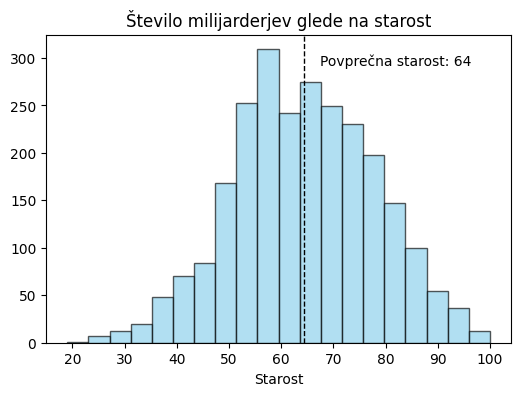

In [17]:
forbes_age = forbes.age.dropna()
plot_starost = plt.hist(forbes_age, bins=20, color='skyblue', edgecolor='k', alpha=0.65)
plt.axvline(forbes_age.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(forbes_age.mean()*1.05, max_ylim * 0.9, 'Povprečna starost: {:.0f}'.format(forbes_age.mean()))
plt.rcParams["figure.figsize"] = (6,4)
plt.title('Število milijarderjev glede na starost')
plt.xlabel('Starost')

<h4>NACIONALNOST</h4>

In [7]:
# ZEMLJEVID:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

# priprava in merging podatkov:
# popravljanje imen držav:
forbes['country_n'] = forbes['country'].replace({'Eswatini (Swaziland)' :'eSwatini',
                                                                   'Guernsey' : 'United Kingdom',
                                                                   'Hong Kong' : 'China',
                                                                   'Monaco' : 'France',
                                                                   'Singapore' : 'Malaysia',
                                                                   'St. Kitts and Nevis' : 'United Kingdom',
                                                                   'United States' : 'United States of America',
                                                                   'Barbados' : 'United Kingdom'})
drzave['country_n'] = drzave['country'].replace({'Eswatini' :'eSwatini',
                                               'Guernsey' : 'United Kingdom',
                                               'Hong Kong' : 'China',
                                               'Monaco' : 'France',
                                               'Singapore' : 'Malaysia',
                                               'St. Kitts and Nevis' : 'United Kingdom',
                                               'United States' : 'United States of America',
                                               'Barbados' : 'United Kingdom'})
forbes_countries = forbes.groupby("country_n").size().reset_index(name = "forbes_count")
forbes_countries = pd.merge(forbes_countries, drzave, how='left', on='country_n')
forbes_countries['forbes_na_preb'] = forbes_countries['forbes_count'] / forbes_countries['population']

# merging:
world = world.rename({'name': 'country_n'}, axis = 1)
world = pd.merge(world, forbes_countries, how='left', on='country_n')

# izrisovanje zemljevida:
custom_scale = (world['forbes_na_preb'].quantile((0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))).tolist()
map = folium.Map()
zemljevid = folium.Choropleth(
    geo_data = world,
    name = 'choropleth',
    data = world,
    columns = ['country_n', 'forbes_na_preb'],
    key_on = 'feature.properties.country_n',
    threshold_scale = custom_scale, #use the custom scale we created for legend
    fill_color = 'YlGnBu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend = False,
    nan_fill_color = 'white'
    ).add_to(map)
for key in zemljevid._children:
    if key.startswith('color_map'):
        del(zemljevid._children[key])
        
zemljevid.add_to(map)

map

Text(0.5, 1.0, 'Število milijarderjev glede na število prebivalcev po posameznih državah')

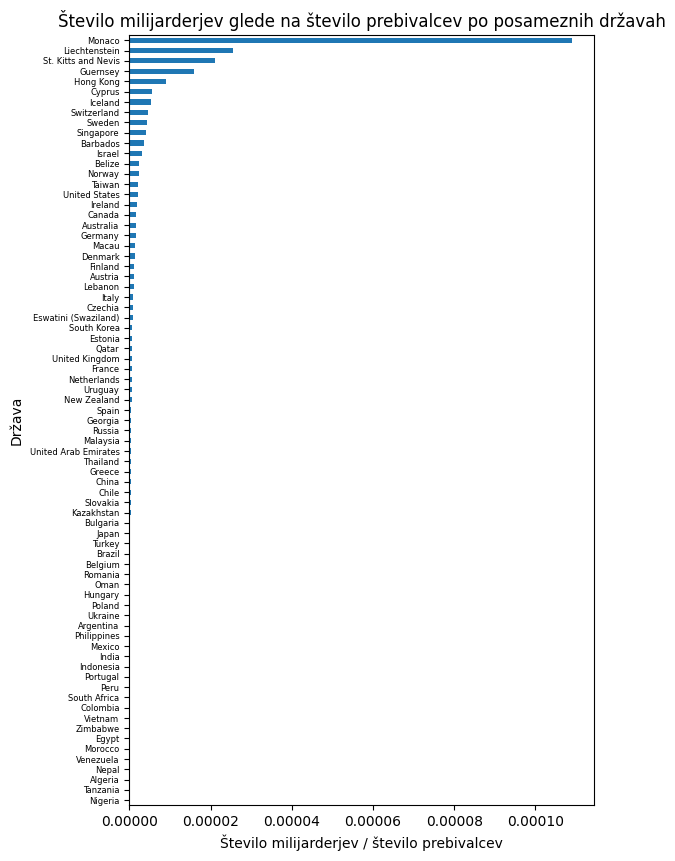

In [20]:
# GRAF:
forbes_countries = forbes.groupby("country").size().reset_index(name = "forbes_count")
forbes_countries = pd.merge(forbes_countries, drzave, how='left', on='country')
forbes_countries['forbes_na_preb'] = forbes_countries['forbes_count'] / forbes_countries['population']
forbes_countries = forbes_countries.sort_values(by = 'forbes_na_preb', ascending = True)

forbes_countries_plot = forbes_countries.plot.barh(x = 'country', 
                           y = 'forbes_na_preb',
                           legend = False)
plt.yticks(size=6)
plt.xlabel('Število milijarderjev / število prebivalcev')
plt.ylabel('Država')
plt.rcParams['figure.figsize'] = [6,10]
plt.title('Število milijarderjev glede na število prebivalcev po posameznih državah')

<h4>NET WORTH GLEDE NA STAROST</h4>

Text(0, 0.5, 'Networth v milijardah')

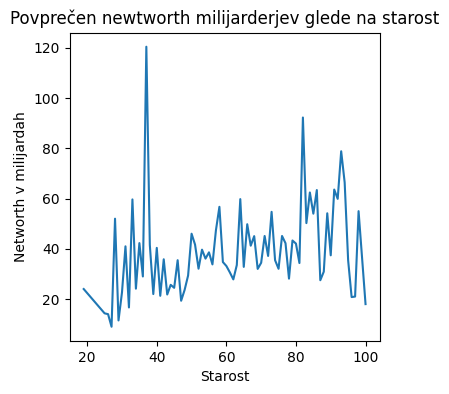

In [44]:
plt.rcParams['figure.figsize'] = [4,4]
forbes_networth_age_plot = forbes.groupby('age')['networth'].mean().plot().set_title('Povprečen newtworth milijarderjev glede na starost')
plt.xlabel('Starost')
plt.ylabel('Networth v milijardah')

<h4>INDUSTRIJA</h4>

<AxesSubplot: title={'center': 'Miljarderji glede na industrijo vira prihodka'}>

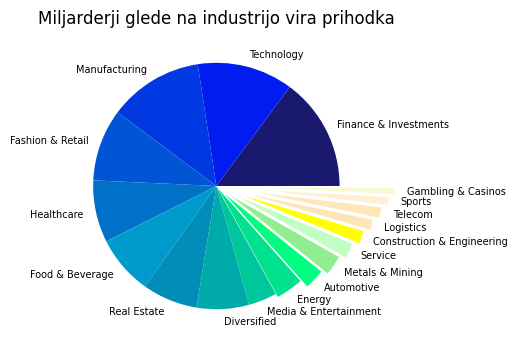

In [89]:
colors = ['#191970', '#001CF0','#0038E2', '#0055D4', '#0071C6', '#009ACD', '#008DB8','#00AAAA','#00C69C','#00E28E','#00FF80', '#90EE90','#C1FFC1','#FFFF00', '#FFE4B5', '#FFE7BA', '#FFEFD5', '#FAFAD2']
forbes.groupby('industry').size().sort_values(ascending = False).plot.pie(
    explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0.03, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45),
    colors = colors,
    title = 'Miljarderji glede na industrijo vira prihodka',
    textprops={'fontsize': 7})